In [1]:
from statsforecast import StatsForecast
from statsforecast.models import (Naive, SeasonalNaive, AutoARIMA, AutoETS, AutoTheta, AutoCES)
from datasetsforecast.losses import mse, mae, smape
from data_loading_finance.loading_data import LoadingData
from ts_tools.tools import tools
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from typing import List, Callable
from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [222]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2019-01-01', end='2023-12-31', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})

# Calcular los retornos
Y_df['y'] = np.log(Y_df['y'].div(Y_df.groupby('unique_id')['y'].shift(1)))
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)
Y_df


[*********************100%%**********************]  8 of 8 completed


,ds,unique_id,y
0,2019-02-01,AAPL,0.039523
1,2019-03-01,AAPL,0.096882
2,2019-04-01,AAPL,0.054901
3,2019-05-01,AAPL,-0.136476
4,2019-06-01,AAPL,0.126521
...,...,...,...
467,2023-08-01,NVDA,0.054674
468,2023-09-01,NVDA,-0.126301
469,2023-10-01,NVDA,-0.064464
470,2023-11-01,NVDA,0.137050


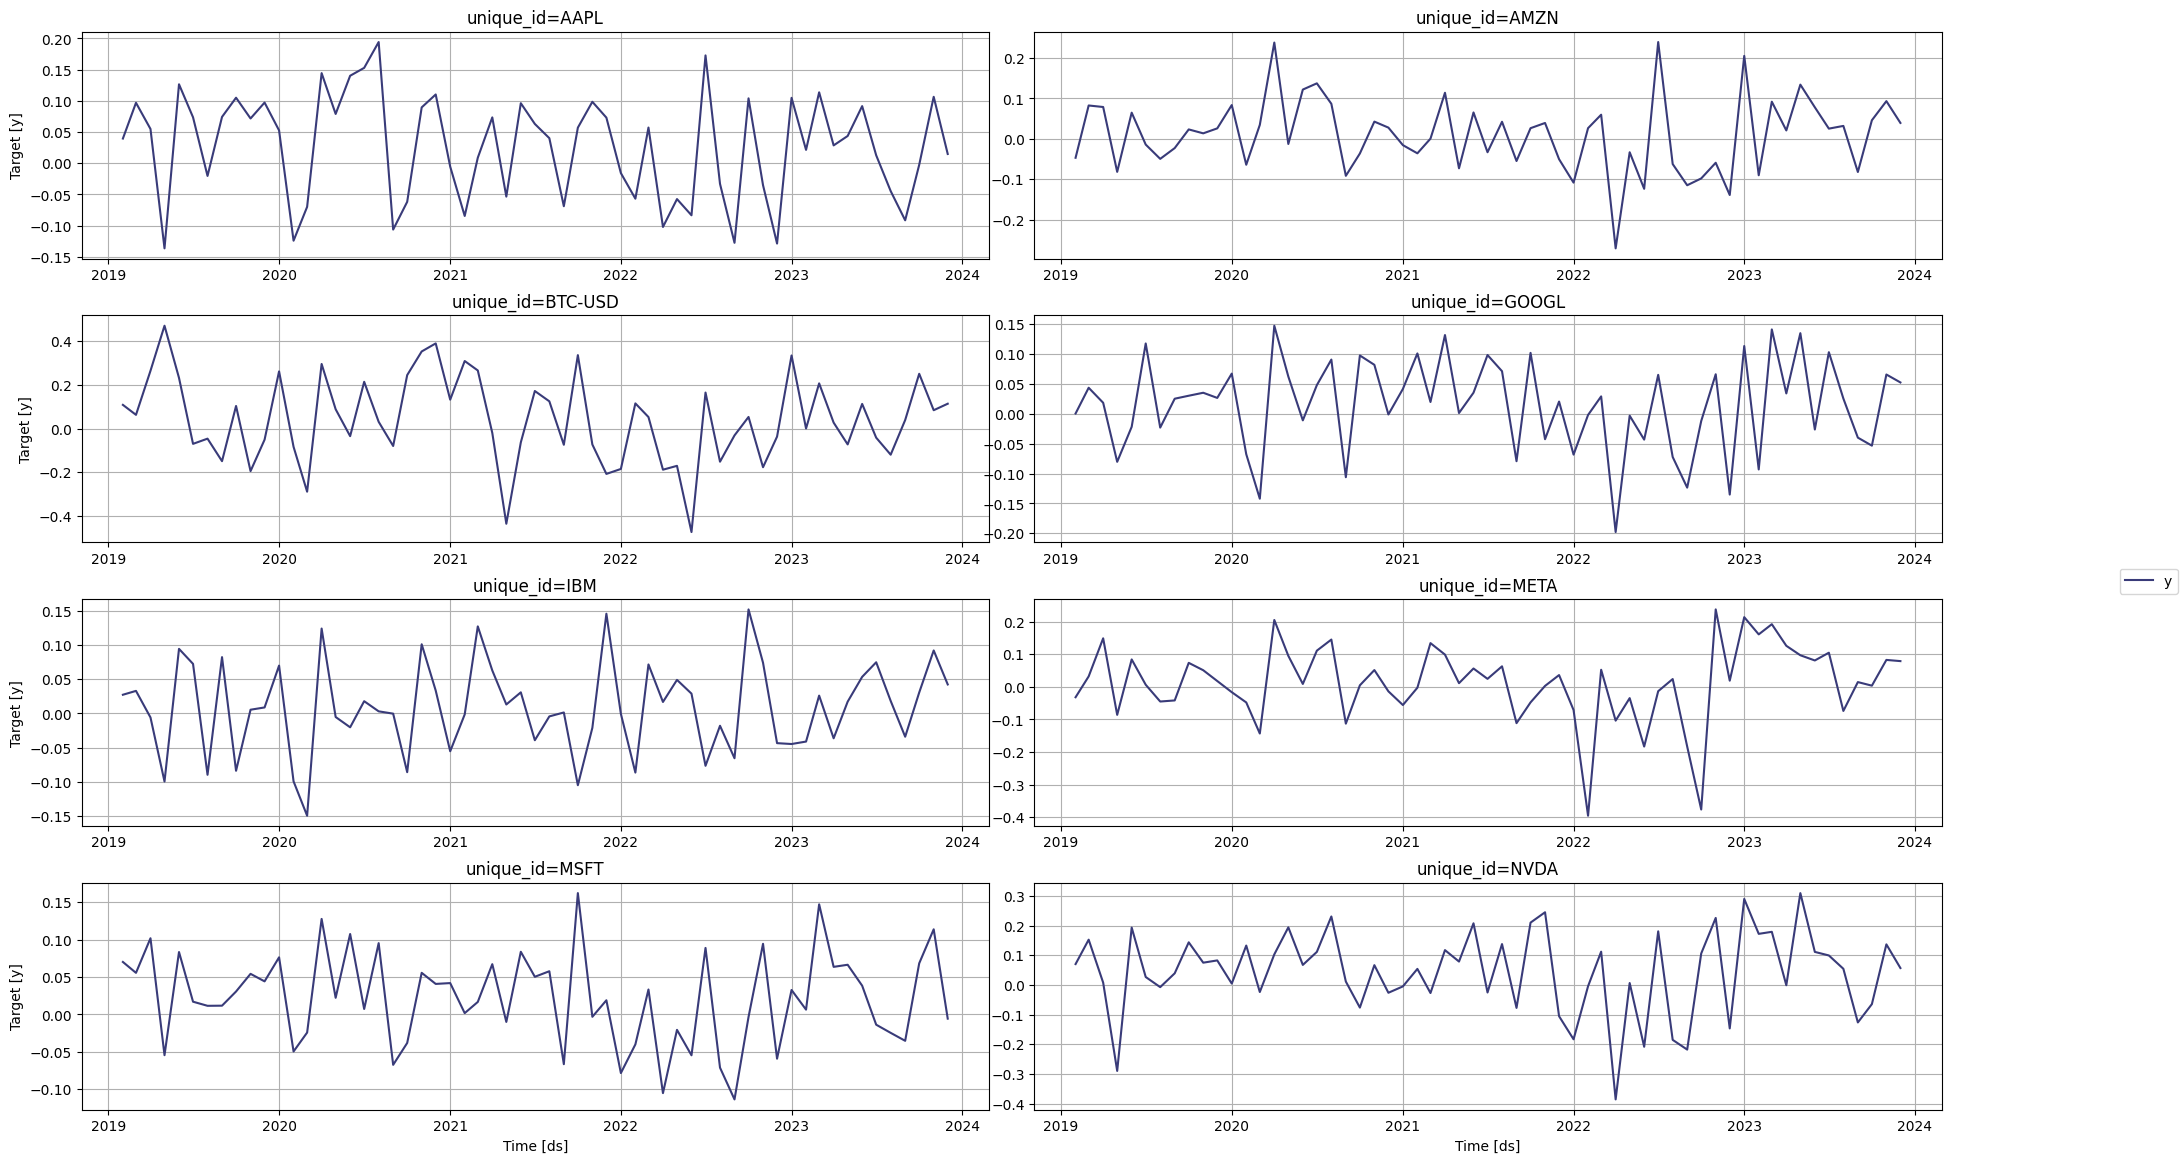

In [223]:
StatsForecast.plot(Y_df)

In [224]:
season_length = 12 # Define season length as 12 months for monthly data
horizon = 1 # Forecast horizon is set to 1 month

# Define a list of models for forecasting
models = [
    Naive(),
    SeasonalNaive(season_length=season_length),
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
]

# Instantiate StatsForecast class with models, data frequency ('MS' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='MS',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [225]:
# Generate forecasts for the specified horizon using the sf object
Y_hat_df = sf.forecast(df=Y_df, h=horizon) # forecast data
Y_hat_df.head() 

,ds,Naive,SeasonalNaive,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,,,
AAPL,2024-01-01,0.014808,0.104829,0.021517,0.026714,0.011821,0.013759
AMZN,2024-01-01,0.039263,0.205174,0.000000,0.009602,0.018290,0.047008
BTC-USD,2024-01-01,0.113966,0.335297,0.027094,0.041942,0.040052,0.153255
GOOGL,2024-01-01,0.052617,0.113555,0.000000,0.015444,0.017188,0.035699
IBM,2024-01-01,0.042263,-0.044707,0.000000,0.008112,0.025318,-0.005942


In [226]:
cv_df = sf.cross_validation(df=Y_df, h=horizon, n_windows=3, step_size=horizon, level=[90])
cv_df.head()

,ds,cutoff,y,Naive,Naive-lo-90,Naive-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,AutoARIMA,...,AutoARIMA-hi-90,AutoETS,AutoETS-lo-90,AutoETS-hi-90,AutoTheta,AutoTheta-lo-90,AutoTheta-hi-90,CES,CES-lo-90,CES-hi-90
unique_id,,,,,,,,,,,,,,,,,,,,,
AAPL,2023-10-01,2023-09-01,-0.002573,-0.091510,-0.288086,0.105066,0.103956,-0.082261,0.290172,0.024353,...,0.169420,0.026161,-0.121088,0.173410,0.001791,-0.134655,0.173893,0.031826,-0.151127,0.208784
AAPL,2023-11-01,2023-10-01,0.106443,-0.002573,-0.198365,0.193218,-0.035243,-0.221222,0.150737,-0.008044,...,0.135886,0.025518,-0.120475,0.171511,0.000839,-0.134314,0.171310,0.032550,-0.143314,0.219188
AAPL,2023-12-01,2023-11-01,0.014808,0.106443,-0.089071,0.301957,-0.128762,-0.315891,0.058367,-0.028030,...,0.116863,0.026946,-0.118801,0.172693,0.011843,-0.123837,0.182978,0.020329,-0.161196,0.204494
AMZN,2023-10-01,2023-09-01,0.045894,-0.082195,-0.314101,0.149711,-0.098111,-0.321242,0.125021,0.000000,...,0.154278,0.007040,-0.152624,0.166704,0.001899,-0.145250,0.187501,-0.022294,-0.224295,0.173089
AMZN,2023-11-01,2023-10-01,0.093197,0.045894,-0.185650,0.277438,-0.059320,-0.282766,0.164126,0.000000,...,0.153245,0.007729,-0.150661,0.166120,0.006494,-0.139503,0.190643,0.009696,-0.183220,0.214429


In [227]:
cv_df = pd.DataFrame(cv_df)
cv_df.index.name = 'unique_id'

# Transformar índice en columna
cv_df.reset_index(inplace=True)

In [228]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [229]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

In [230]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})


In [231]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine="dask",
    params={'metrics': [mse, mae, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)
evaluation_df.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask

2024-07-09 13:23:52,981 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 6333863585723520350562384e0dcd4f initialized by task ('shuffle-transfer-6333863585723520350562384e0dcd4f', 3) executed on worker tcp://127.0.0.1:55512
2024-07-09 13:23:56,045 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 6333863585723520350562384e0dcd4f deactivated due to stimulus 'task-finished-1720524236.042089'


,unique_id,cutoff,metric,Naive,SeasonalNaive,AutoARIMA,AutoETS,AutoTheta,CES
0,META,2023-11-01,mse,0.000013,0.003597,0.006204,0.004525,0.001824,0.005821
1,META,2023-11-01,mae,0.003647,0.059976,0.078765,0.067269,0.042708,0.076297
2,META,2023-11-01,smape,4.52516,122.958611,200.0,149.053528,74.389305,187.845703
3,NVDA,2023-11-01,mse,0.00638,0.041458,0.003269,0.000169,0.000031,0.012519
4,NVDA,2023-11-01,mae,0.079875,0.203613,0.057175,0.013009,0.005549,0.111888


In [232]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)


Naive  SeasonalNaive   AutoARIMA     AutoETS  \
cutoff     metric                                                      
2023-09-01 mae       0.085423       0.154126     0.06699    0.067369   
           mse       0.011034        0.03325    0.009271    0.008471   
           smape   143.817337     173.693695  198.285492  154.990189   
2023-10-01 mae       0.103713       0.104662    0.089753    0.075854   
           mse       0.013607        0.01803    0.009075    0.006062   
           smape   137.688507      98.362663  176.107422  133.059753   
2023-11-01 mae       0.055158       0.132913     0.05665    0.037064   
           mse       0.004438        0.02071    0.004016    0.001814   
           smape    80.723358     186.060028   197.78833  112.760071   

                    AutoTheta         CES  
cutoff     metric                          
2023-09-01 mae       0.075381    0.075909  
           mse       0.011671    0.008695  
           smape   174.634476  151.117706  
2023-10-01 mae        0.08051    0.057108  
           mse       0.006801     0.00463  
           smape   146.472565  100.737617  
2023-11-01 mae       0.032029     0.05595  
           mse        0.00169    0.004384  
           smape    88.073067  148.441711

In [233]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')

<Axes: xlabel='error', ylabel='model'>

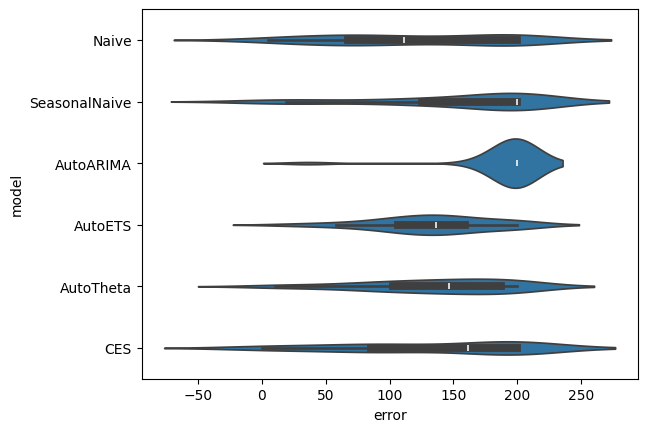

In [234]:
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

<Axes: xlabel='n', ylabel='best_model'>

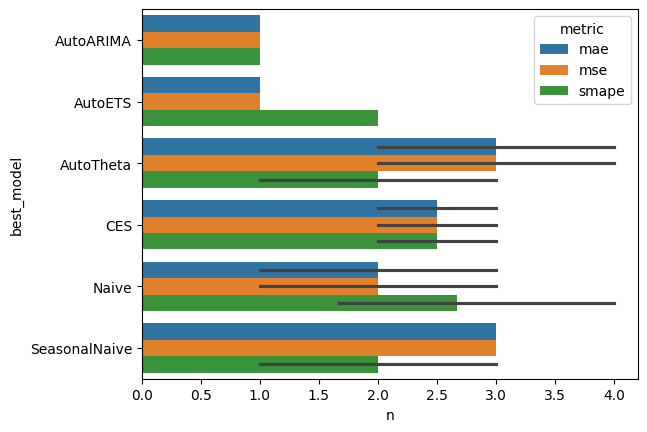

In [235]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')